In [76]:
import __init__ # set up all the correct referenses
import os

subproject_name = "trajectories"

wd = "../../../"
project_path = os.path.realpath(wd)
print(project_path)

raw_data_dir = project_path+"/raw_data/"
print(raw_data_dir)


data_dir = project_path+f"/{subproject_name}"+"/data/"
print(data_dir)

results_dir = project_path+f"/{subproject_name}"+"/output"
print(results_dir)

import pandas as pd
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle

import seaborn as sns

from sklearn.neighbors import NearestNeighbors, KDTree, kneighbors_graph
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler,PowerTransformer, QuantileTransformer
import sklearn.preprocessing as preprocessing
from sklearn.manifold import TSNE

from sknetwork.clustering import Louvain, get_modularity

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

from phenograph.cluster import cluster as cluster2
from phenograph.cluster import run_leiden 

#import gower

cmap = plt.get_cmap("tab20")

import __init__
from utils.propensity import Propensity
#from utils.lifelines_preprocess import surv_functions
from utils.sequence_analysis import trajectory_seq_analysis

import leidenalg
import igraph as ig

/exports/reum/nsteinz/Project_trajectories
/exports/reum/nsteinz/Project_trajectories/raw_data/
/exports/reum/nsteinz/Project_trajectories/trajectories/data/
/exports/reum/nsteinz/Project_trajectories/trajectories/output


In [77]:
features_nl = [#'total Pijn',
            'TJC_28',
            #'TJC_44',
            #'total Zwelling',
            'SJC_28',
            #'SJC_44',
            #'Alkalische Fosfatase',
            #'Anti-CCP Kwant.',
            'BSE',
            #'C-Reaktief Proteïne',
            'Leukocyten',
            #'Hematocriet',
            #'Hemoglobine',
            "hb_corrected",
            #'IgM reumafactor',
                #'Anti-CCP',
            #'MCH',
            #'MCHC',
            'MCV',
            'Trombocyten',
            #'Ferritine',
            #"Sex",
           ]

features = [#'total Pijn',
            'TJC_28',
            #'TJC_44',
            #'total Zwelling',
            'SJC_28',
            #'SJC_44',
            #'Alkalische Fosfatase',
            #'Anti-CCP Kwant.',
            'ESR',
            #'C-Reaktief Proteïne',
            'leukocytes',
            #'Hematocriet',
            #'hemoglobin',
            "hb_corrected",
            #'IgM reumafactor',
                #'Anti-CCP',
            #'MCH',
            #'MCHC',
            'MCV',
            'thrombocytes',
            #'Ferritine',
            #"Sex",
           ]

dmards = ['ABATACEPT', 'ADALIMUMAB', 'ANAKINRA',
       'SODIUM_AUROTHIOMALATE', 'AZATHIOPRINE', 'BARICITINIB',
       'CERTOLIZUMAB_PEGOL', 'CICLOSPORINE', 'CYCLOPHOSPHAMIDE', 'ETANERCEPT',
       'GOLIMUMAB', 'HYDROXYCHLOROQUINE', 'INFLIXIMAB', 'LEFLUNOMIDE',
       'METHOTREXATE', 'SULFASALAZINE',
       'TOCILIZUMAB', 'TOFACITINIB', 'METHYLPREDNISOLONE', 'PREDNISOLONE']
dmard_types = {
    "TNF_b_dmards" : ['ETANERCEPT', 'GOLIMUMAB','INFLIXIMAB','CERTOLIZUMAB_PEGOL', 'ADALIMUMAB'],
    "IL6_b_dmards" : ['CERTOLIZUMAB_PEGOL', 'TOCILIZUMAB'],
    "IL1_b_dmards" : ['ANAKINRA'],
    "tcell_b_dmards" : ['ABATACEPT'],
    "cs_dmards" : ["METHOTREXATE",'HYDROXYCHLOROQUINE','LEFLUNOMIDE', 'SULFASALAZINE'],
    "jak_dmard" : ['TOFACITINIB', 'BARICITINIB'],
    "XO_damrd" : ['AZATHIOPRINE'],
    "OP_dmard" : ["CYCLOPHOSPHAMIDE"],
    "TC_dmard" : ["CICLOSPORINE"],
    "gld_dmard": ["SODIUM_AUROTHIOMALATE"]
    #"predni":  ['PREDNISOLONE',"METHYLPREDNISOLONE"],
}

predni=  ['PREDNISOLONE',"METHYLPREDNISOLONE"]
set(dmards)- set([j for x in dmard_types for j in dmard_types[x]])

feature_remap = dict(zip(features_nl,features))
dmard_types.items()

dict_items([('TNF_b_dmards', ['ETANERCEPT', 'GOLIMUMAB', 'INFLIXIMAB', 'CERTOLIZUMAB_PEGOL', 'ADALIMUMAB']), ('IL6_b_dmards', ['CERTOLIZUMAB_PEGOL', 'TOCILIZUMAB']), ('IL1_b_dmards', ['ANAKINRA']), ('tcell_b_dmards', ['ABATACEPT']), ('cs_dmards', ['METHOTREXATE', 'HYDROXYCHLOROQUINE', 'LEFLUNOMIDE', 'SULFASALAZINE']), ('jak_dmard', ['TOFACITINIB', 'BARICITINIB']), ('XO_damrd', ['AZATHIOPRINE']), ('OP_dmard', ['CYCLOPHOSPHAMIDE']), ('TC_dmard', ['CICLOSPORINE']), ('gld_dmard', ['SODIUM_AUROTHIOMALATE'])])

In [78]:
datasamples_use =  pd.read_csv(data_dir+"/predictie_data.csv",)
data_use = pd.read_csv(results_dir + "merged_new_data.csv")
print(len(datasamples_use))
print(len(data_use))
data_use.loc[data_use.BSE <3,"BSE"] = 2
#X_embedded = TSNE(n_components=2, learning_rate='auto',
#                  init='random', perplexity=100).fit_transform(data_use[list(features)].fillna(0).values)
data_use
data_use.DATUM = pd.to_datetime(data_use.DATUM)
#print(data_use)
#data_use = data_use[data_use.PATNR.isin(datasamples_use.PATNR.unique())]
#list(data_use.columns)
data_use[["PATNR"]]
data_use.rename(columns=feature_remap)

data_use.DATUM = pd.to_datetime(data_use.DATUM)


5017
5089


beznr                     object
bezdat            datetime64[ns]
HAQTOTAALSCORE           float64
Pseudo_id                float64
patient_id_old             int64
patient_id_new             int64
dtype: object

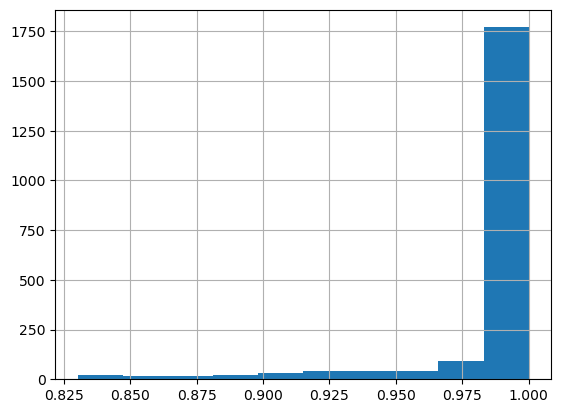

In [79]:
probs_ra  = pd.read_csv(raw_data_dir+"data_03_12_22/" +"tjardo_RA_probability.csv", sep="|")
key_match_raw = pd.read_csv("/exports/reum/knevel_lab/pseudo_id_old_to_new/id_link.csv")
probs_ra
key_match = key_match_raw.merge(probs_ra, right_on="PATNR", left_on="patient_id_new")[["patient_id_old","prediction"]]
#key_match
key_match.prediction.hist()
haq_scores =  pd.read_csv(raw_data_dir+"haq_scores_EAC_2024_02_19.csv")
haq_scores = haq_scores.merge(key_match_raw, left_on="Pseudo_id", right_on="patient_id_new")
haq_scores.bezdat = pd.to_datetime(haq_scores.bezdat)
haq_scores = haq_scores.dropna()
haq_scores.dtypes

In [80]:
medication = pd.read_csv(data_dir +"medication_linked_v2.csv")
medication.DATUM = pd.to_datetime(medication.DATUM)
#medication = medication.merge(data_heatmap[["PATNR","DATUM", "days","label","to_clust"]], on=["PATNR","DATUM"],how="outer")
medication = medication.fillna(False)

data_use = data_use.merge(medication, on=["PATNR","DATUM"], how="left", suffixes=["_old", ""]).fillna(False)


/tmp/ipykernel_197998/3116567877.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_use = data_use.merge(medication, on=["PATNR","DATUM"], how="left", suffixes=["_old", ""]).fillna(False)


In [81]:
data_meds = pd.read_csv(raw_data_dir+"data_03_12_22/" + "NewPatSelection_Medicator_formatted_20221202.csv", sep="|", parse_dates=True,)
data_meds.startDate = pd.to_datetime(data_meds.startDate)
data_meds.endDate = pd.to_datetime(data_meds.endDate.fillna(pd.to_datetime('1/1/2023').date()))


print(len(data_meds.query("endDate=='2023-01-01'")))
data_meds = data_meds.rename(columns={"patnr":"PATNR"})
data_meds.loc[data_meds.extractDose=="0", "extractDose"] = "1"


/tmp/ipykernel_197998/4256273134.py:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  print(len(data_meds.query("endDate=='2023-01-01'")))


4552


In [82]:
data_use["dmard_usage"] = data_use[list(dmard_types)].sum(axis=1) >0
data_use["m_dmards"] = data_use[dmards[:-2]].sum(axis=1) >1



/tmp/ipykernel_197998/2700740740.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_use["m_dmards"] = data_use[dmards[:-2]].sum(axis=1) >1


In [83]:
data_use = data_use.merge(key_match, left_on="PATNR", right_on="patient_id_old", how="left")

In [84]:
dmard_baseline = data_use.sort_values("DATUM").query("dmard_usage == True").groupby("PATNR").head(1)[["PATNR", "DATUM"]]
dmard_baseline = dmard_baseline.rename(columns = {"DATUM":"dmard_baseline_datum"})
dmard_baseline = data_use[["PATNR","DATUM"]].merge(dmard_baseline, how="inner")


In [85]:
dmard_baseline["days_DMARD"] = (dmard_baseline.DATUM - dmard_baseline.dmard_baseline_datum).dt.days
data_use = data_use.merge(dmard_baseline, how="left")


In [86]:
data_use["das44"] =(0.53938*np.sqrt(data_use.TJC_44) + 0.06465 * data_use.SJC_44 + 0.33 * np.log(data_use.BSE)) + 0.224

In [87]:
data_use.Leukocyten.describe()
data_use = data_use.query("Leukocyten< 25")

In [88]:
df = pd.read_csv(data_dir + "merged_david_data.csv",)
df["mcv"] = (df['Hematocrit (L/L)']/df["Erythrocytes (10*12/L)"] * 1000).round(1)
df = df.drop(columns=["Erythrocytes (10*12/L)",'Hematocrit (L/L)'])


<Axes: >

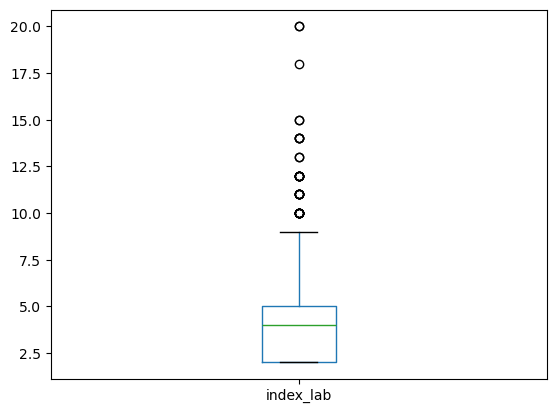

In [89]:
data_use.groupby("PATNR").count().boxplot("index_lab", grid=False)

In [90]:
data_use["das28"] =(0.56*np.sqrt(data_use.TJC_28) + 0.28* np.sqrt( data_use.SJC_28) + 0.70*np.log(data_use.BSE))*1.08 + 0.16
df["das28"] =(0.56*np.sqrt(df.tjc28) + 0.28* np.sqrt( df.sjc28) + 0.70*np.log(df.ESR))*1.08 + 0.16
#df["das44"] =(0.53938*np.sqrt(df.tjc44) + 0.06465 * df.sjc44 + 0.33 * np.log(df.ESR)) + 0.224

In [91]:
for i in list(dmard_types.keys())+["predni"]:
    data_use[i] = (data_use[i] > 0 )* 1
# adds a row that shows if a patient uses multiple dmards
data_use["m_dmards"] = data_use[dmard_types.keys()].sum(axis=1) > 1


In [92]:
data_use.loc[data_use[["Hemoglobine","Sex"]].query("Sex==True").index ,"hb_corrected"]= (data_use[["Hemoglobine","Sex"]].query("Sex==True").Hemoglobine +0.5) 
data_use.loc[data_use[["Hemoglobine","Sex"]].query("Sex==False").index ,"hb_corrected"]= (data_use[["Hemoglobine","Sex"]].query("Sex==False").Hemoglobine -0.5)

In [93]:
list(data_use.columns)

['index_lab',
 'PATNR_lab',
 'DATUM',
 'Pijn_elleboog_links',
 'Pijn_ip_links',
 'Pijn_ip_rechts',
 'Pijn_ip_linkervoet',
 'Pijn_ip_rechtervoet',
 'Pijn_manubrio_sternaal_gewricht',
 'Pijn_acromioclaviculair_links',
 'Pijn_acromioclaviaculair_rechts',
 'Pijn_bovenste_spronggewricht_links',
 'Pijn_bovenste_spronggewricht_rechts',
 'Pijn_cervical_spine',
 'Pijn_cmc_1_links',
 'Pijn_cmc_1_rechts',
 'Pijn_dip_2_linkerhand',
 'Pijn_dip_2_linkervoet',
 'Pijn_dip_2_rechterhand',
 'Pijn_dip_2_rechtervoet',
 'Pijn_dip_3_linkerhand',
 'Pijn_dip_3_linkervoet',
 'Pijn_dip_3_rechterhand',
 'Pijn_dip_3_rechtervoet',
 'Pijn_dip_4_linkerhand',
 'Pijn_dip_4_linkervoet',
 'Pijn_dip_4_rechterhand',
 'Pijn_dip_4_rechtervoet',
 'Pijn_dip_5_linkerhand',
 'Pijn_dip_5_linkervoet',
 'Pijn_dip_5_rechterhand',
 'Pijn_dip_5_rechtervoet',
 'Pijn_elleboog_rechts',
 'Pijn_heup_links',
 'Pijn_heup_rechts',
 'Pijn_knie_links',
 'Pijn_knie_rechts',
 'Pijn_mcp_1_links',
 'Pijn_mcp_1_rechts',
 'Pijn_mcp_2_links',
 'Pijn_

In [94]:
data_use.columns

Index(['index_lab', 'PATNR_lab', 'DATUM', 'Pijn_elleboog_links',
       'Pijn_ip_links', 'Pijn_ip_rechts', 'Pijn_ip_linkervoet',
       'Pijn_ip_rechtervoet', 'Pijn_manubrio_sternaal_gewricht',
       'Pijn_acromioclaviculair_links',
       ...
       'TC_dmard', 'gld_dmard', 'm_dmards', 'patient_id_old', 'prediction',
       'dmard_baseline_datum', 'days_DMARD', 'das44', 'das28', 'hb_corrected'],
      dtype='object', length=291)

In [95]:
data_use["hb_corrected"] = data_use.hb_corrected.astype(float)

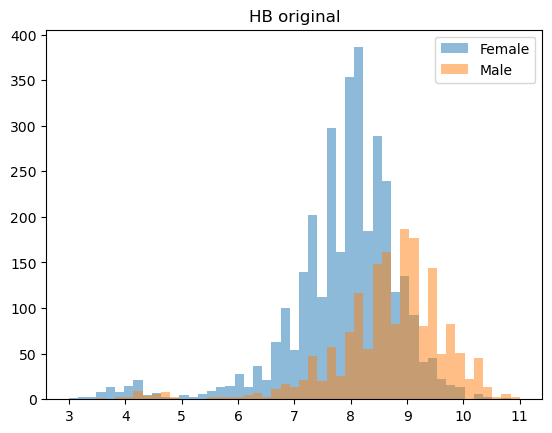

In [96]:
x = data_use.query("Sex == True").Hemoglobine
y = data_use.query("Sex == False").Hemoglobine
bins = np.linspace(3, 11, 50)
plt.hist(x, bins, alpha=0.5, label='Female')
plt.hist(y, bins, alpha=0.5, label='Male')
plt.title("HB original")
plt.legend()

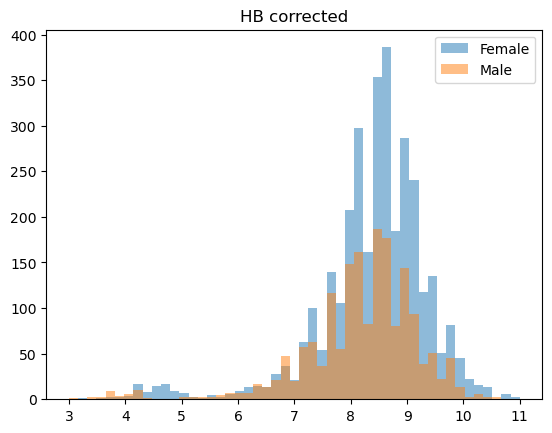

In [97]:
x = data_use.query("Sex == True").hb_corrected
y = data_use.query("Sex == False").hb_corrected

bins = np.linspace(3, 11, 50)
plt.hist(x, bins, alpha=0.5, label='Female')
plt.hist(y, bins, alpha=0.5, label='Male')
plt.title("HB corrected")
plt.legend()

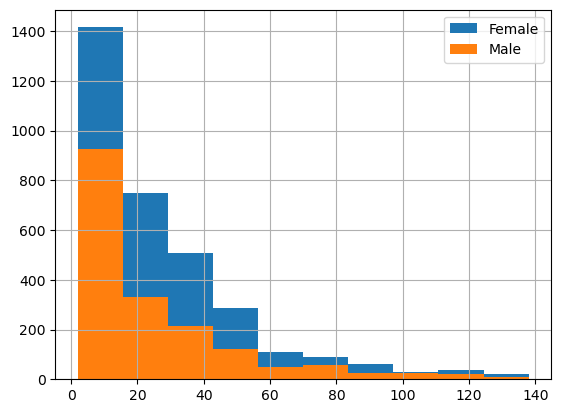

In [98]:
data_use.query("Sex == True").BSE.hist(label='Female')
data_use.query("Sex == False").BSE.hist(label='Male')
plt.legend()

female: mean= 26.88762969678654, std= 25.190235968244497, n# = 3309
male  : mean= 24.308426966292135, std= 25.940966986252555, n# = 1780


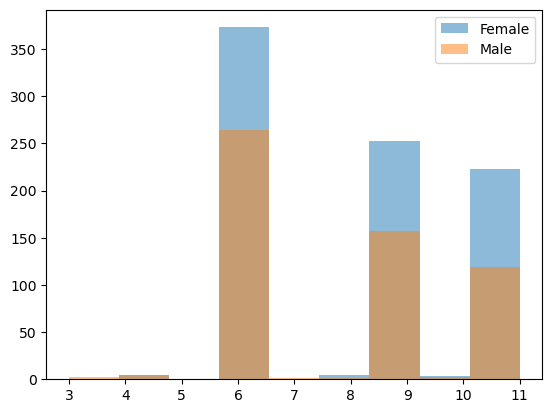

In [99]:
x = data_use.query("Sex == True").BSE
y = data_use.query("Sex == False").BSE
bins = np.linspace(3, 11, 10)
plt.hist(x, bins, alpha=0.5, label='Female')
plt.hist(y, bins, alpha=0.5, label='Male')
plt.legend()
print(f"female: mean= {x.mean()}, std= {x.std()}, n# = {len(x)}")
print(f"male  : mean= {y.mean()}, std= {y.std()}, n# = {len(y)}")

In [101]:
data_cluster = datasamples_use
data_cluster = data_cluster.rename(columns=feature_remap)
data_cluster = data_cluster.loc[data_cluster[features].dropna().index]
data_cluster = data_cluster.reset_index(drop=True)
feature_remap
data_cluster.MCV = data_cluster.MCV.astype(float)
data_cluster.thrombocytes = data_cluster.thrombocytes.astype(float)
len(data_cluster)

5017

In [102]:
df_features = ['tjc28', 'sjc28', 'ESR', 'Leucocytes',
        'Hemoglobin',  'mcv', 'Thrombocytes']
df = df[['patient_id', 'visit_date',  'tjc28', 'sjc28', 'ESR', 'Leucocytes',
        'Hemoglobin',  'mcv', 'Thrombocytes','das28','delta_time']]



In [103]:
data_cluster.columns
#data_cluster["double_pos"] = (data_cluster[["acpa", "RF"]].sum(axis=1) == 2).astype(bool)
#data_cluster["sero_negative"] = (data_cluster[["acpa", "RF"]].sum(axis=1) == 0).astype(bool)
#data_cluster["seropos"] = (data_cluster[["acpa", "RF"]].sum(axis=1) >= 1).astype(bool)
#data_cluster["aCCP positive"] = (data_cluster[["acpa"]] >= 1).astype(bool)
#data_cluster["RF positive"] = (data_cluster[["RF"]]>= 1).astype(bool)

data_cluster[["aCCP positive", "RF positive", "double_pos", "sero_negative"]]

data_description = data_cluster.copy()



In [104]:
features_o = [x+"_o" for x in features]

In [105]:
from scipy import stats
from IPython.display import display, Markdown, display_markdown
def print_describe_markdown(dataset, name="fill in",index=True):
    main_text = ""
    main_text += f"{'|features'*index} | {name} | \n"
    main_text += "|:-------|-------:|\n"
    main_text +=  f"| N= | {len(dataset)} |\n"
    for i in features +["Hemoglobine","das28", "dmard_usage", "sex", "days","seropos", "RF positive", "aCCP positive"]:
        
        #print(dataset[i])
        if dataset[i].dtypes == "object":
            continue
        elif dataset[i].dtypes == "bool":
             main_text += f"|{i*index} {'(%)'*index} | {round(dataset[i].sum(),1)} ({round(dataset[i].mean()*100, 1)})| \n"
             pass
        else:
            main_text += f"|{i*index} {'(±IQR)'*index} | {round(dataset[i].median(),1)}  ({round(dataset[i].quantile(q=0.25),1)} - { round(dataset[i].quantile(q=0.75),1)})| \n"
            pass
    return display_markdown(main_text, raw=True)
print_describe_markdown(data_description, index=True)
#display_markdown(text, raw=True)


|features | fill in | 
|:-------|-------:|
| N= | 5017 |
|TJC_28 (±IQR) | 0.1  (0.0 - 0.2)| 
|SJC_28 (±IQR) | 0.1  (0.0 - 0.2)| 
|ESR (±IQR) | 0.1  (0.1 - 0.2)| 
|leukocytes (±IQR) | 0.3  (0.2 - 0.3)| 
|hb_corrected (±IQR) | 0.7  (0.6 - 0.7)| 
|MCV (±IQR) | 0.8  (0.8 - 0.8)| 
|thrombocytes (±IQR) | 0.3  (0.3 - 0.4)| 
|Hemoglobine (±IQR) | 8.2  (7.7 - 8.8)| 
|das28 (±IQR) | 3.5  (2.5 - 4.6)| 
|dmard_usage (%) | 4003 (79.8)| 
|sex (±IQR) | 1.0  (0.0 - 1.0)| 
|days (±IQR) | 132.0  (2.0 - 301.0)| 
|seropos (%) | 2927 (58.3)| 
|RF positive (%) | 2498 (49.8)| 
|aCCP positive (%) | 2450 (48.8)| 


In [106]:
data_description.sort_values("DATUM").groupby("PATNR").head(1)[list(dmard_types.keys())].sum()

TNF_b_dmards       88
IL6_b_dmards       15
IL1_b_dmards        0
tcell_b_dmards      9
cs_dmards         882
jak_dmard          11
XO_damrd            9
OP_dmard            3
TC_dmard            0
gld_dmard           0
dtype: int64

In [107]:
data_description.sort_values("DATUM").groupby("PATNR").head(1).Age.describe()

count    1237.000000
mean       59.817300
std        14.727369
min        17.000000
25%        51.000000
50%        61.000000
75%        71.000000
max        97.000000
Name: Age, dtype: float64

In [108]:
# first visit description 
print_describe_markdown(data_description.sort_values("DATUM").groupby("PATNR").head(1))

|features | fill in | 
|:-------|-------:|
| N= | 1237 |
|TJC_28 (±IQR) | 0.1  (0.1 - 0.3)| 
|SJC_28 (±IQR) | 0.1  (0.0 - 0.3)| 
|ESR (±IQR) | 0.2  (0.1 - 0.3)| 
|leukocytes (±IQR) | 0.3  (0.2 - 0.3)| 
|hb_corrected (±IQR) | 0.7  (0.6 - 0.7)| 
|MCV (±IQR) | 0.8  (0.8 - 0.8)| 
|thrombocytes (±IQR) | 0.3  (0.3 - 0.4)| 
|Hemoglobine (±IQR) | 8.2  (7.5 - 8.8)| 
|das28 (±IQR) | 4.3  (3.3 - 5.3)| 
|dmard_usage (%) | 970 (78.4)| 
|sex (±IQR) | 1.0  (0.0 - 1.0)| 
|days (±IQR) | 0.0  (0.0 - 0.0)| 
|seropos (%) | 683 (55.2)| 
|RF positive (%) | 570 (46.1)| 
|aCCP positive (%) | 571 (46.2)| 


In [109]:
# last visit description 
print_describe_markdown(data_description.sort_values("DATUM").groupby("PATNR").tail(1))

|features | fill in | 
|:-------|-------:|
| N= | 1237 |
|TJC_28 (±IQR) | 0.0  (0.0 - 0.1)| 
|SJC_28 (±IQR) | 0.0  (0.0 - 0.1)| 
|ESR (±IQR) | 0.1  (0.0 - 0.2)| 
|leukocytes (±IQR) | 0.2  (0.2 - 0.3)| 
|hb_corrected (±IQR) | 0.7  (0.6 - 0.8)| 
|MCV (±IQR) | 0.8  (0.8 - 0.8)| 
|thrombocytes (±IQR) | 0.3  (0.3 - 0.4)| 
|Hemoglobine (±IQR) | 8.3  (7.7 - 8.9)| 
|das28 (±IQR) | 2.9  (2.1 - 3.9)| 
|dmard_usage (%) | 983 (79.5)| 
|sex (±IQR) | 1.0  (0.0 - 1.0)| 
|days (±IQR) | 375.0  (224.0 - 462.0)| 
|seropos (%) | 683 (55.2)| 
|RF positive (%) | 570 (46.1)| 
|aCCP positive (%) | 571 (46.2)| 


In [110]:
data_description.sort_values("DATUM").groupby("PATNR").head(1).thrombocytes.astype(float).describe()

count    1237.000000
mean        0.357156
std         0.110595
min         0.000000
25%         0.285714
50%         0.336818
75%         0.408827
max         0.865273
Name: thrombocytes, dtype: float64

In [111]:
from sklearn.decomposition import PCA
pca_data = data_cluster[features].dropna(axis=0).values
components = 3
pca = PCA(n_components=components).fit(pca_data)
pca_trans = pca.transform(pca_data)
principalDf = pd.DataFrame(data = pca_trans
             , columns = [f'principal component {x}' for x in range(1,components+1)])
principalDf
pca.explained_variance_ratio_


array([0.43606838, 0.2278866 , 0.12598099])

In [112]:
X_embedded = TSNE(n_components=2, learning_rate='auto',n_jobs = -1,
                  init='random', perplexity=100).fit_transform(principalDf)

<Axes: xlabel='one', ylabel='two'>

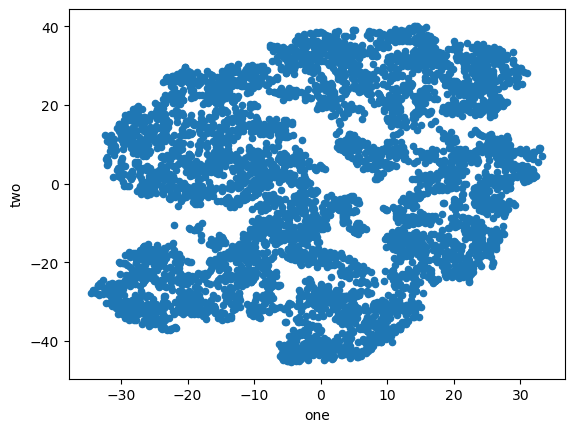

In [113]:
tsne_df = pd.DataFrame(X_embedded, columns=[
    "one","two",
    #"three"
    ])
tsne_df.plot.scatter("one","two")
#tsne_df.plot.scatter("one","three")
#tsne_df.plot.scatter("two","three")

dist_gower = gower.gower_matrix(data_cluster[list(features)+["Sex", "RF", "Anti_CCP"]])

Text(0.5, 0, 'amount of vistits')

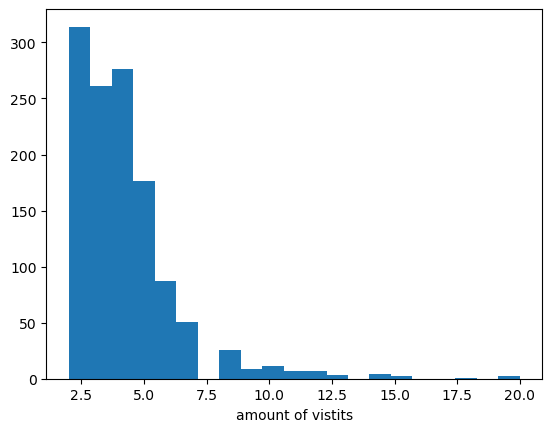

In [114]:
ax = data_cluster.groupby("PATNR").count().Age.hist(bins=21,grid=False)
ax.set_xlabel("amount of vistits")
#print(data_cluster.groupby("PATNR").count().Age.median())
#data_cluster.groupby("PATNR").count().Age.describe()

In [115]:
# make adjecentie matrix

scaler =MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(data_cluster[features].values)
data_used = scaler.transform(data_cluster[features].values)


In [116]:
from phenograph.cluster import cluster as cluster2
#K = 110
K = 250
communities, graph, modularity = cluster2(data_used, k=K, seed= 20221003, primary_metric="cosine", clustering_algo="leiden")

Finding 250 nearest neighbors using cosine metric and 'brute' algorithm
Neighbors computed in 0.7266688346862793 seconds
Jaccard graph constructed in 32.50481557846069 seconds
Running Leiden optimization
Leiden completed in 6.3267059326171875 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 41.68164420127869 seconds


In [117]:
data_cluster["label"] = communities + 1

#data_cluster_ = pd.concat([data_cluster,test_ ], axis=1)

print(data_cluster.groupby("label").PATNR.count())
#print(data_cluster.groupby("label_pheno").PATNR.count())

label
1    1100
2     905
3     681
4     674
5     593
6     531
7     475
8      58
Name: PATNR, dtype: int64


In [118]:
tsne_df
tsne_df["labels"] = data_cluster["label"]
tsne_df["dmard"] = data_cluster.dmard_usage
tsne_df["days"] = data_cluster.days
#tsne_df["days_nlp"] = data_cluster.days_nlp
#tsne_df.plot.scatter("one","two", c = 'labels', cmap="Set1")
#tsne_df.plot.scatter("one","three", c = 'labels', cmap="Set1")
#tsne_df.plot.scatter("three","two", c = 'labels', cmap="Set1")
data_used

array([[0.14285714, 0.16666667, 0.32352941, ..., 0.63059704, 0.90350877,
        0.54123113],
       [0.07142857, 0.125     , 0.05147059, ..., 0.60820894, 0.9122807 ,
        0.30778165],
       [0.07142857, 0.08333333, 0.14705882, ..., 0.70895528, 1.        ,
        0.27642276],
       ...,
       [0.        , 0.        , 0.02941176, ..., 0.69776121, 0.78070175,
        0.43321719],
       [0.        , 0.        , 0.22794118, ..., 0.66417909, 0.74561404,
        0.46225319],
       [0.        , 0.        , 0.06617647, ..., 0.68656713, 0.78070175,
        0.34727062]])

In [119]:
pca_data = data_cluster[features]

components = 3
pca = PCA(n_components=components).fit(pca_data)
pca_trans = pca.transform(pca_data)
principalDf = pd.DataFrame(data = pca_trans
             , columns = [f'principal component {x}' for x in range(1,components+1)]
                          )
principalDf["label"] = data_cluster["label"] 
principalDf["days"] = data_cluster.days
pca.explained_variance_ratio_
principalDf

,principal component 1,principal component 2,principal component 3,label,days
0,0.230598,-0.177929,-0.358671,6,0
1,-0.084762,0.021326,-0.080432,3,20
2,-0.087110,-0.028660,-0.086950,3,259
3,-0.125618,-0.143742,0.346842,8,0
4,-0.162794,-0.061543,0.000093,4,147
...,...,...,...,...,...
5012,-0.229978,-0.022635,0.032626,1,0
5013,-0.223137,-0.023823,-0.004914,3,308
5014,-0.173593,-0.069149,-0.212227,3,0
5015,-0.039841,-0.212436,-0.181495,3,216


,principal component 1,principal component 2,principal component 3,label,days
0,0.230598,-0.177929,-0.358671,6,0
1,-0.084762,0.021326,-0.080432,3,20
2,-0.087110,-0.028660,-0.086950,3,259
3,-0.125618,-0.143742,0.346842,8,0
4,-0.162794,-0.061543,0.000093,4,147
...,...,...,...,...,...
5012,-0.229978,-0.022635,0.032626,1,0
5013,-0.223137,-0.023823,-0.004914,3,308
5014,-0.173593,-0.069149,-0.212227,3,0
5015,-0.039841,-0.212436,-0.181495,3,216


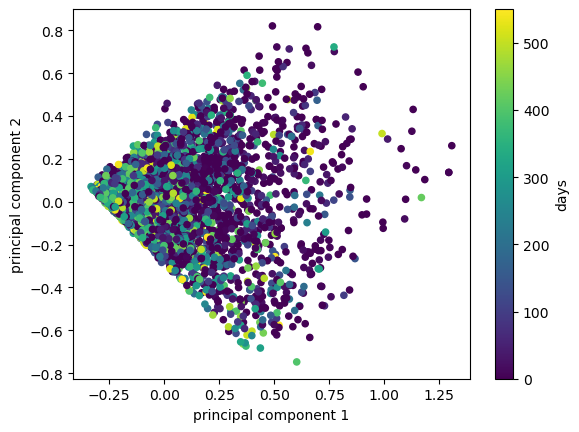

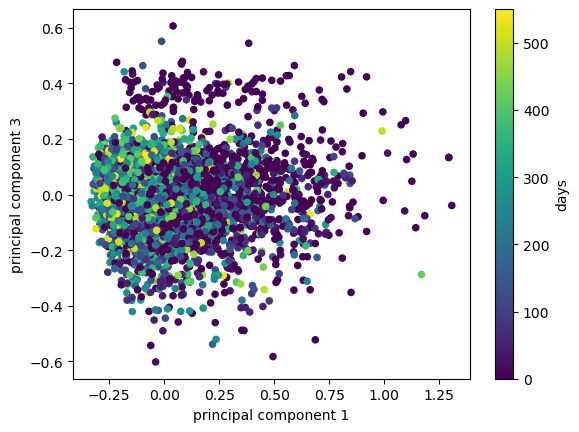

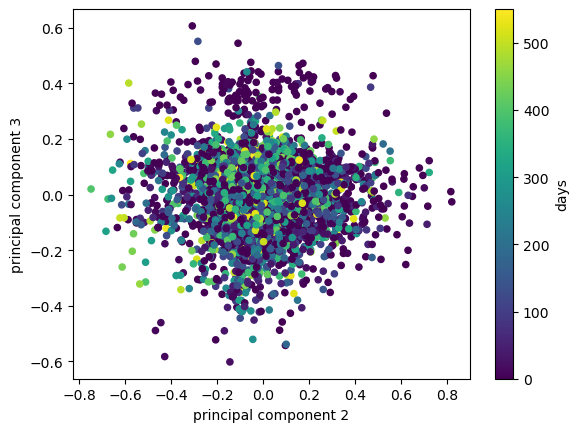

In [120]:

principalDf.plot.scatter(x="principal component 1", y="principal component 2", c="days", colormap="viridis")
principalDf.plot.scatter(x="principal component 1", y="principal component 3", c="days", colormap="viridis")
principalDf.plot.scatter(x="principal component 2", y="principal component 3", c="days", colormap="viridis")
#principalDf.plot.scatter(x="principal component 1", y="principal component 4", c="label", cmap="Set1")
principalDf

In [121]:
import umap
def draw_umap(data, n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', title='', target= "label"):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    tsne_ng = pd.DataFrame(u, columns=["one","two"])
    tsne_ng["labels"] = target
    if n_components == 1:
        ax.scatter(u[:,0], range(len(u)), c=tsne_ng.labels)
    if n_components == 2:
        tsne_ng.plot.scatter("one","two", c = 'labels', cmap="tab10")
    plt.title(title, fontsize=18)
    return tsne_ng

,one,two,labels
0,7.450752,8.139857,6
1,10.848187,7.367682,3
2,11.070029,7.396796,3
3,3.657443,5.962843,8
4,12.025407,8.922128,4
...,...,...,...
5012,12.468210,7.692258,1
5013,11.371756,8.350120,3
5014,10.220648,8.176884,3
5015,8.362322,8.472253,3


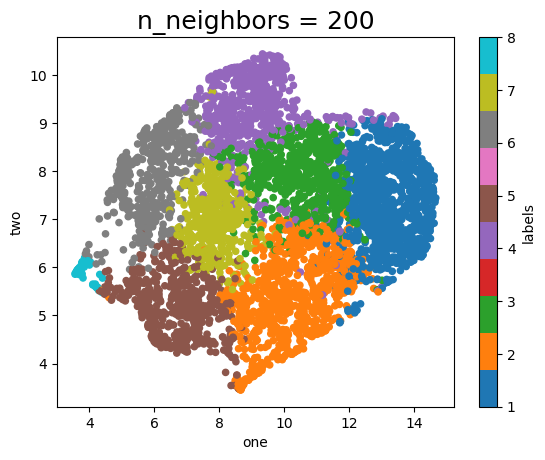

In [122]:
#for n in (2, 5, 10, 20, 30,50, 100, 200):
#    draw_umap(data=data_used,n_neighbors=n, title='n_neighbors = {}'.format(n), metric="cosine", target=data_cluster["label"])
draw_umap(data=data_used,n_neighbors=200, title='n_neighbors = {}'.format(200), metric="cosine", target=data_cluster["label"])

In [123]:
data_cluster.query("symptomDuration < 0").symptomDuration.describe()

count      46.000000
mean     -744.869565
std       885.047911
min     -1991.000000
25%     -1991.000000
50%      -141.000000
75%       -99.000000
max        -6.000000
Name: symptomDuration, dtype: float64

In [130]:
data_heatmap = pd.DataFrame(data_used, columns = features)
#data_heatmap["SJC"] = scaler_minmax.fit_transform( data_use.SJC_28.values.reshape(-1,1))
#data_heatmap["TJC"] = scaler_minmax.fit_transform(data_use.TJC_28.values.reshape(-1,1))
for f in features:
    data_heatmap[f"{f}_o"] = data_cluster[f].values
data_heatmap["das28_n"] = scaler.fit_transform(data_cluster["das28"].values.reshape(-1,1))
data_heatmap["das28"] = data_cluster["das28"].values
data_heatmap["das44"] = data_cluster["das44"]
data_heatmap["SJC_44_o"] = data_cluster["SJC_44"].values
data_heatmap["TJC_44_o"] = data_cluster["TJC_44"].values
data_heatmap["aCCP positive"] = data_cluster['acpa'].astype(int)
data_heatmap["RF positive"] = data_cluster['RF'].astype(int) 
data_heatmap["label"] = data_cluster["label"].astype(int)
#data_heatmap["label_pheno"] = data_cluster["label_pheno"].astype(int)
data_heatmap["days"] = data_cluster.days
data_heatmap["days_nlp"] = data_cluster.days_nlp
data_heatmap["PATNR"] = data_cluster.PATNR
data_heatmap["DATUM"] = data_cluster.DATUM
data_heatmap["Age"] = data_cluster.Age
data_heatmap["sex"] = data_cluster.Sex.astype(int)
data_heatmap["dmard_usage"] = data_cluster.dmard_usage
data_heatmap["symptomDuration"] = data_cluster["symptomDuration"]
data_heatmap["days_DMARD"] = data_cluster["days_DMARD"]
data_heatmap["Hemoglobine"] = data_cluster["Hemoglobine"]
data_heatmap['sequence']=data_heatmap.sort_values("DATUM").groupby('PATNR').cumcount()
data_heatmap["Age_n"] = scaler.fit_transform(data_cluster["Age"].values.reshape(-1,1))

data_heatmap["remision"] = data_heatmap.query("days > 90").das28 < 2.6

features_o = [f"{x}_o" for x in features]
data_heatmap[dmards] = data_cluster[dmards]
for i in dmard_types:
    data_heatmap[i] = data_cluster[i]
    
data_heatmap["count"] = 1
data_heatmap["dmard_usage"] = data_heatmap[dmards].sum(axis=1) >= 1
data_heatmap["no_med"] = (~data_heatmap["dmard_usage"] * 1)
data_heatmap["med"] = (data_heatmap["dmard_usage"] * 1)     
    
#data_heatmap[dmard_types.keys()] = data_cluster[dmard_types.keys()]
#data_heatmap = data_heatmap.dropna(axis=0)
volgorde= pd.Index(list(range(len(data_heatmap.label.unique()),0,-1))).astype(int)
volgorde_base = data_heatmap.groupby("label").days.mean().sort_values().index
#volgorde_pheno = data_heatmap.groupby("label_pheno").days.mean().sort_values().index
data_heatmap.label = data_heatmap.label.replace(dict(zip(volgorde_base,volgorde)))
data_heatmap["to_clust"] = data_heatmap.sort_values("days").groupby(["PATNR"]).label.shift(-1,axis=0, fill_value=-1)
data_heatmap["label_text"]= data_heatmap.label.astype(str)
data_heatmap["to_clust_text"] = data_heatmap.sort_values("days").groupby(["PATNR"]).label_text.shift(-1,axis=0, fill_value=-1)
data_heatmap["label"]= data_heatmap.label.astype(int)
#data_heatmap["label_pheno"]=data_heatmap.label_pheno
data_heatmap["to_clust"]=data_heatmap.to_clust.astype(int)



volgorde_text = volgorde.astype(str)
data_heatmap["label"]

try: 
    traject_label = pd.read_csv("traject_label.csv")
    data_heatmap = data_heatmap.join(traject_label.set_index('PATNR'), on="PATNR", how="left")
    data_heatmap.traject_label = data_heatmap.traject_label.dropna().astype(int).replace({1:"A",2:"B",3:"C",4:"D"})
except FileNotFoundError as e:
    None


KeyError: 'SJC_44'

In [131]:
data_heatmap = datasamples_use

In [132]:
data_heatmap["seq"] = data_heatmap.sort_values("DATUM").groupby("PATNR").cumcount()


In [133]:
data_heatmap["no_disease"] = False
data_heatmap.loc[data_heatmap.query("SJC_44_o == 0 & TJC_44_o == 0 & ESR_o <=30").index,"no_disease"] =True
data_heatmap

data_heatmap["double_pos"] = (data_heatmap[["aCCP positive", "RF positive"]].sum(axis=1) == 2).astype(bool)
data_heatmap["sero_negative"] = (data_heatmap[["aCCP positive", "RF positive"]].sum(axis=1) == 0).astype(bool)
data_heatmap["seropos"] = (data_heatmap[["aCCP positive", "RF positive"]].sum(axis=1) >= 1).astype(bool)
data_heatmap["aCCP positive"] = (data_heatmap[["aCCP positive"]] >= 1).astype(bool)
data_heatmap["RF positive"] = (data_heatmap[["RF positive"]]>= 1).astype(bool)

In [134]:
#data_heatmap = datasamples_use
volgorde= pd.Index(list(range(len(data_heatmap.label.unique()),0,-1))).astype(int)
data_heatmap.columns

Index(['TJC_28', 'SJC_28', 'ESR', 'leukocytes', 'hb_corrected', 'MCV',
       'thrombocytes', 'TJC_28_o', 'SJC_28_o', 'ESR_o', 'leukocytes_o',
       'hb_corrected_o', 'MCV_o', 'thrombocytes_o', 'das28_n', 'das28',
       'das44', 'SJC_44_o', 'TJC_44_o', 'aCCP positive', 'RF positive',
       'label', 'days', 'days_nlp', 'PATNR', 'DATUM', 'Age', 'sex',
       'dmard_usage', 'symptomDuration', 'Hemoglobine', 'sequence', 'Age_n',
       'remision', 'ABATACEPT', 'ADALIMUMAB', 'ANAKINRA',
       'SODIUM_AUROTHIOMALATE', 'AZATHIOPRINE', 'BARICITINIB',
       'CERTOLIZUMAB_PEGOL', 'CICLOSPORINE', 'CYCLOPHOSPHAMIDE', 'ETANERCEPT',
       'GOLIMUMAB', 'HYDROXYCHLOROQUINE', 'INFLIXIMAB', 'LEFLUNOMIDE',
       'METHOTREXATE', 'SULFASALAZINE', 'TOCILIZUMAB', 'TOFACITINIB',
       'METHYLPREDNISOLONE', 'PREDNISOLONE', 'TNF_b_dmards', 'IL6_b_dmards',
       'IL1_b_dmards', 'tcell_b_dmards', 'cs_dmards', 'jak_dmard', 'XO_damrd',
       'OP_dmard', 'TC_dmard', 'gld_dmard', 'count', 'no_med', 'med',
 

In [135]:
data_heatmap["from_clust"] = data_heatmap.sort_values("days").groupby(["PATNR"]).label.shift(1,axis=0, fill_value=-1)


/tmp/ipykernel_197998/4213887943.py:1: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  data_heatmap["from_clust"] = data_heatmap.sort_values("days").groupby(["PATNR"]).label.shift(1,axis=0, fill_value=-1)


In [136]:
data_heatmap.columns

Index(['TJC_28', 'SJC_28', 'ESR', 'leukocytes', 'hb_corrected', 'MCV',
       'thrombocytes', 'TJC_28_o', 'SJC_28_o', 'ESR_o', 'leukocytes_o',
       'hb_corrected_o', 'MCV_o', 'thrombocytes_o', 'das28_n', 'das28',
       'das44', 'SJC_44_o', 'TJC_44_o', 'aCCP positive', 'RF positive',
       'label', 'days', 'days_nlp', 'PATNR', 'DATUM', 'Age', 'sex',
       'dmard_usage', 'symptomDuration', 'Hemoglobine', 'sequence', 'Age_n',
       'remision', 'ABATACEPT', 'ADALIMUMAB', 'ANAKINRA',
       'SODIUM_AUROTHIOMALATE', 'AZATHIOPRINE', 'BARICITINIB',
       'CERTOLIZUMAB_PEGOL', 'CICLOSPORINE', 'CYCLOPHOSPHAMIDE', 'ETANERCEPT',
       'GOLIMUMAB', 'HYDROXYCHLOROQUINE', 'INFLIXIMAB', 'LEFLUNOMIDE',
       'METHOTREXATE', 'SULFASALAZINE', 'TOCILIZUMAB', 'TOFACITINIB',
       'METHYLPREDNISOLONE', 'PREDNISOLONE', 'TNF_b_dmards', 'IL6_b_dmards',
       'IL1_b_dmards', 'tcell_b_dmards', 'cs_dmards', 'jak_dmard', 'XO_damrd',
       'OP_dmard', 'TC_dmard', 'gld_dmard', 'count', 'no_med', 'med',
 

In [137]:

data_heatmap.groupby(["label", "PATNR"]).head(1).groupby("label")[["sex", "Age","seropos","aCCP positive", "RF positive"]].mean().round(2).T

label,1,2,3,4,5,6,7,8
sex,0.60,0.71,0.64,0.64,0.72,0.68,0.58,0.69
Age,57.45,60.97,58.73,57.45,61.41,63.98,62.87,56.27
seropos,0.56,0.66,0.58,0.49,0.60,0.60,0.46,0.67
aCCP positive,0.47,0.57,0.50,0.40,0.50,0.52,0.34,0.44
RF positive,0.46,0.54,0.51,0.41,0.53,0.50,0.41,0.64


In [138]:
data_heatmap.groupby(["label", "PATNR"]).head(1).groupby("label")[["sex", "Age","seropos","aCCP positive", "RF positive"]].count().T

label,1,2,3,4,5,6,7,8
sex,601,396,394,520,330,266,391,55
Age,601,396,394,520,330,266,391,55
seropos,601,396,394,520,330,266,391,55
aCCP positive,601,396,394,520,330,266,391,55
RF positive,601,396,394,520,330,266,391,55


In [139]:
data_heatmap.query("symptomDuration >0").groupby(["label", "PATNR"]).head(1).groupby("label")["symptomDuration"].describe().round(2).T

label,1,2,3,4,5,6,7,8
count,187.00,122.00,135.00,167.00,113.00,89.00,151.00,18.00
mean,683.98,863.66,745.79,768.64,644.43,555.96,517.81,207.08
std,1546.59,1854.42,1478.02,1656.74,1400.12,1209.32,1250.46,190.92
min,5.00,14.00,2.00,2.00,7.00,2.00,5.00,31.00
25%,62.00,62.00,77.50,62.00,77.50,47.00,43.00,62.00
50%,155.00,132.25,186.00,171.00,156.00,124.00,124.00,155.00
75%,455.50,730.00,628.75,457.25,730.00,434.00,291.50,263.50
max,9126.00,9126.00,8395.00,9126.00,9126.00,7300.00,8395.00,730.00


In [140]:
data_heatmap.groupby("label")[["PREDNISOLONE",'TNF_b_dmards', 'IL6_b_dmards',
       'IL1_b_dmards', 'tcell_b_dmards', 'cs_dmards', 'jak_dmard', 'XO_damrd',
       'OP_dmard', 'TC_dmard']].mean().round(2)

,PREDNISOLONE,TNF_b_dmards,IL6_b_dmards,IL1_b_dmards,tcell_b_dmards,cs_dmards,jak_dmard,XO_damrd,OP_dmard,TC_dmard
label,,,,,,,,,,
1,0.40,0.07,0.01,0.0,0.00,0.72,0.01,0.01,0.00,0.0
2,0.41,0.08,0.02,0.0,0.01,0.72,0.01,0.01,0.00,0.0
3,0.44,0.06,0.01,0.0,0.00,0.75,0.01,0.01,0.00,0.0
4,0.42,0.09,0.01,0.0,0.01,0.75,0.01,0.01,0.00,0.0
5,0.48,0.08,0.01,0.0,0.01,0.75,0.01,0.01,0.00,0.0
6,0.38,0.05,0.01,0.0,0.01,0.72,0.01,0.00,0.00,0.0
7,0.41,0.08,0.01,0.0,0.01,0.76,0.01,0.01,0.01,0.0
8,0.34,0.05,0.00,0.0,0.00,0.66,0.00,0.00,0.02,0.0


In [141]:
traject_mapper = dict(zip(range(1,27),"ABCDEFGHIJKLMNOPQRSTUVWXYZ"))
traject_unmapper = dict(zip(traject_mapper.values(),traject_mapper.keys()))


In [142]:
#fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
#plt.xlim(0,500)
x= data_heatmap.query("symptomDuration != 0 & 0 < symptomDuration < 3000").sort_values("DATUM").groupby("PATNR").head(1)
volgorde

Index([8, 7, 6, 5, 4, 3, 2, 1], dtype='int64')

In [143]:
len(data_heatmap.query("SJC_44_o == 0 & TJC_44_o == 0 & ESR_o <30").PATNR.unique())

402

<Axes: >

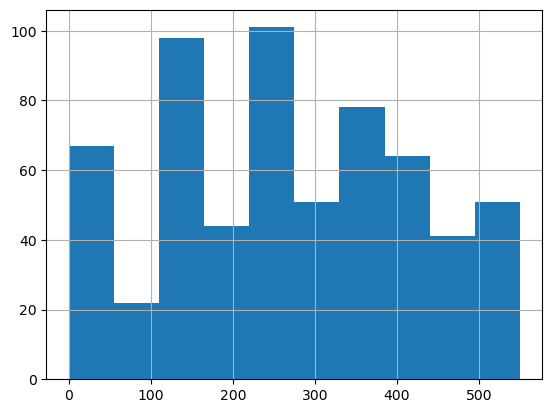

In [144]:
data_heatmap.query("SJC_44_o == 0 & TJC_44_o == 0 & ESR_o <30").days.hist()

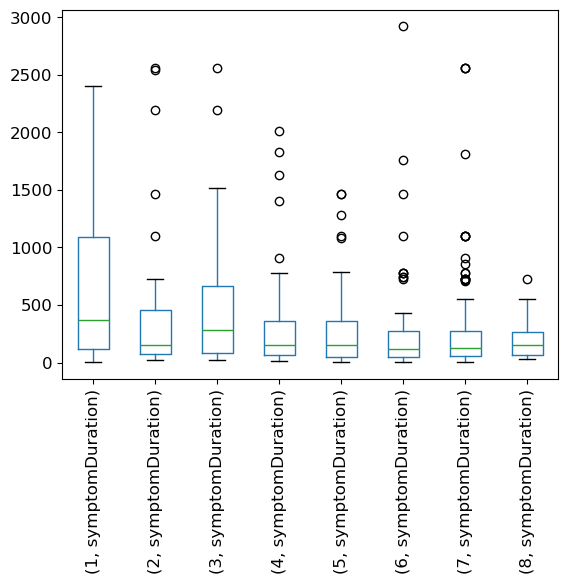

In [145]:
fig, ax = plt.subplots()
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
x[["label","symptomDuration"]].groupby("label")[["symptomDuration"]].boxplot(
    subplots=False, rot=90, fontsize=12, grid=False)
plt.show()

<Axes: title={'center': 'das44'}, xlabel='label'>

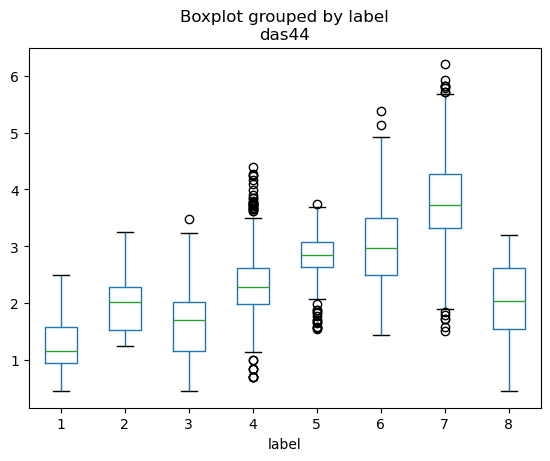

In [146]:
data_heatmap.boxplot(column=f"das44", by="label", grid=False)

In [147]:
x = pd.DataFrame(data_used, columns = features)
x["lable"] = data_cluster["label"].astype(int).astype(str)
data_heatmap.groupby("label")[[x for x in features ]+["das28_n","aCCP positive","RF positive", "sex"]].mean().transpose()[volgorde.astype(int)]

label,8,7,6,5,4,3,2,1
TJC_28,0.107143,0.422308,0.157856,0.172556,0.198856,0.053021,0.047478,0.029026
SJC_28,0.094828,0.451237,0.170982,0.169912,0.121087,0.037139,0.032085,0.014432
ESR,0.125887,0.221376,0.579331,0.243839,0.060897,0.084904,0.237863,0.044098
leukocytes,0.089310,0.307426,0.349119,0.295401,0.240866,0.402784,0.260261,0.191713
hb_corrected,0.240736,0.638667,0.556416,0.668445,0.724623,0.709859,0.675705,0.723151
MCV,0.797641,0.769337,0.779750,0.786460,0.802795,0.805657,0.806136,0.813617
thrombocytes,0.310885,0.371618,0.453821,0.366072,0.304059,0.356586,0.335399,0.283758
das28_n,0.373777,0.646546,0.591571,0.536280,0.375746,0.271574,0.384145,0.178586
aCCP positive,0.413793,0.355818,0.534840,0.524211,0.387845,0.550661,0.602374,0.500000
RF positive,0.620690,0.419899,0.572505,0.553684,0.396685,0.516887,0.587537,0.490000


In [148]:
features_figure = ['TJC_28',
 'SJC_28',
 'ESR',
 'Leukocytes',
 'Hemoglobine (adj.)',
 'MCV',
 'Thrombocytes']


/tmp/ipykernel_197998/836509656.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  size = df.groupby("label").apply(lambda x:len(x))
/tmp/ipykernel_197998/836509656.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  uni_pat = df.groupby("label").apply(lambda x:len(x.PATNR.unique()))


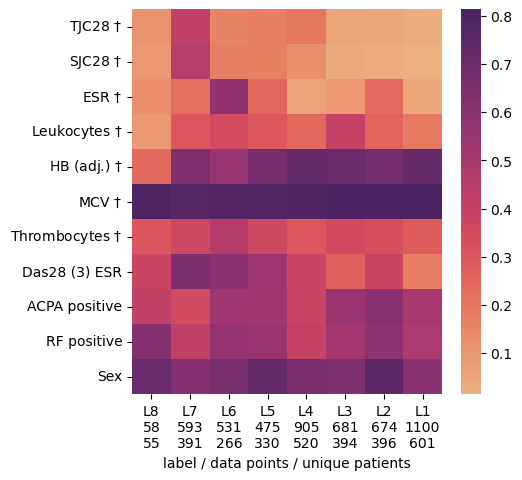

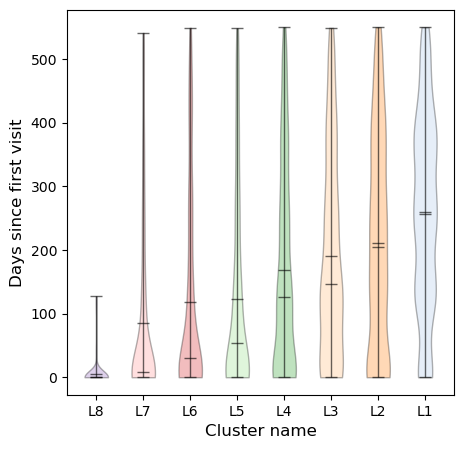

In [149]:
#plt.rcParams.update({'font.size': 10})
cmap = plt.get_cmap("tab20")
def heatmap_plot(df:pd.DataFrame):
    cmap = plt.get_cmap("tab20")
    features_figure = ['TJC28',  'SJC28',   'ESR',  'Leukocytes',  'HB (adj.)',  'MCV',  'Thrombocytes']
    add_features = ["das28_n","aCCP positive","RF positive", "sex"]
    add_features_fig = ["Das28 (3) ESR","ACPA positive","RF positive", "Sex"]
    y_labels = [f"{x} $\dagger$" for x in features_figure if x  ] + add_features_fig
    volgorde= pd.Index(list(range(len(df.label.unique()),0,-1))).astype(int)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    sns.heatmap(df.groupby("label")[
        [x for x in features ]+add_features].mean().transpose()[volgorde],
                cmap="flare", ax=axs,
                yticklabels = y_labels)
    
    size = df.groupby("label").apply(lambda x:len(x))
    uni_pat = df.groupby("label").apply(lambda x:len(x.PATNR.unique()))
    axs.set_xticks(np.array(range(len(size)))+ 0.5)
    axs.set_xticklabels([f"L{i}\n{size.loc[int(i)]}\n{uni_pat.loc[int(i)]}"for i in volgorde])
    axs.set_xlabel("label / data points / unique patients")
    plt.savefig(results_dir+"/heatmap_leiden", dpi=900, transparent=True, bbox_inches='tight')
    fig.show()
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    violin_parts  = axs.violinplot([df[df.label == label].days for label in volgorde],
                      showmeans=True, showextrema=True, showmedians=True, )
    for partname in ('cbars','cmins','cmaxes','cmedians', "cmeans"):
            vp = violin_parts[partname]
            vp.set_edgecolor("black")
            vp.set_linewidth(1)
            vp.set_alpha(0.6) 
    for nr, pc in enumerate(violin_parts["bodies"]):
        pc.set_color(cmap(int(volgorde[nr])))
        pc.set_edgecolor("black")
    axs.set_xticks(range(1,len(volgorde)+1))
    axs.set_xticklabels([f"L{i}"for i in volgorde])
    axs.set_ylabel("Days since first visit", fontsize=12)
    axs.set_xlabel("Cluster name", fontsize=12)
    plt.savefig(results_dir+"/violin_leiden", dpi=900, transparent=True, bbox_inches='tight')
    fig.show()
    #plt.subplots_adjust( left=0.25), dpi=900, transparent=True, bbox_inches='tight')

heatmap_plot(data_heatmap)
#

/tmp/ipykernel_197998/836509656.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  size = df.groupby("label").apply(lambda x:len(x))
/tmp/ipykernel_197998/836509656.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  uni_pat = df.groupby("label").apply(lambda x:len(x.PATNR.unique()))


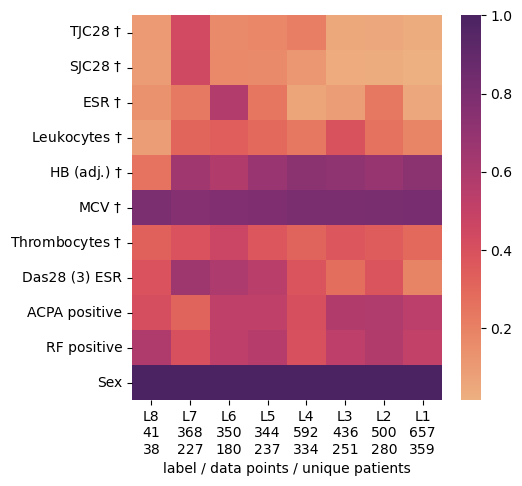

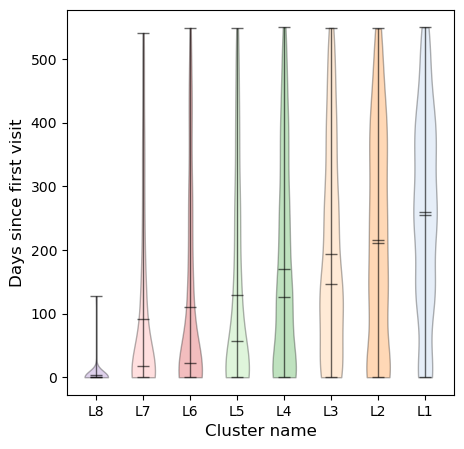

In [150]:
#female
dataset_hm = data_heatmap.query("sex > 0")
heatmap_plot(dataset_hm)

/tmp/ipykernel_197998/836509656.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  size = df.groupby("label").apply(lambda x:len(x))
/tmp/ipykernel_197998/836509656.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  uni_pat = df.groupby("label").apply(lambda x:len(x.PATNR.unique()))


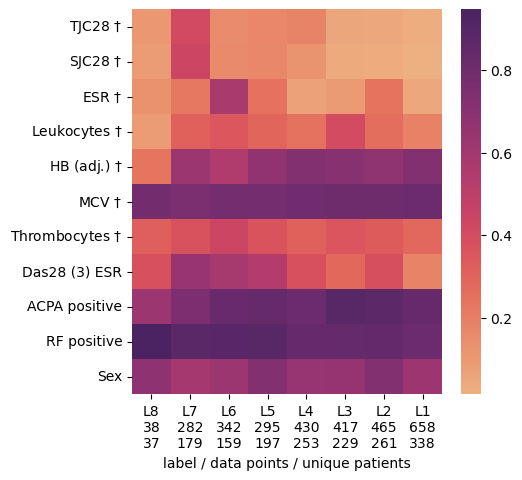

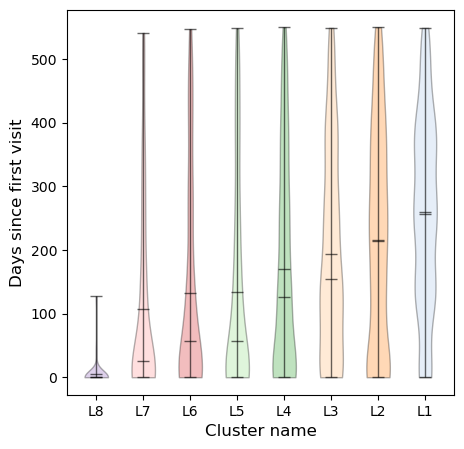

In [151]:
serops_dataset = data_heatmap.query("`aCCP positive` == 1 or `RF positive` ==  1")
#"aCCP positive","RF positive"
#data_heatmap
heatmap_plot(serops_dataset)

/tmp/ipykernel_197998/836509656.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  size = df.groupby("label").apply(lambda x:len(x))
/tmp/ipykernel_197998/836509656.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  uni_pat = df.groupby("label").apply(lambda x:len(x.PATNR.unique()))


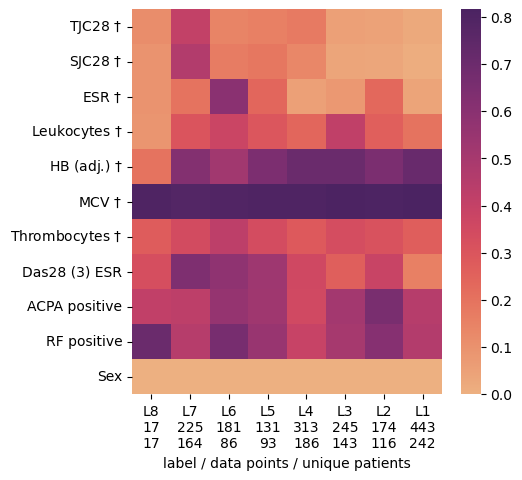

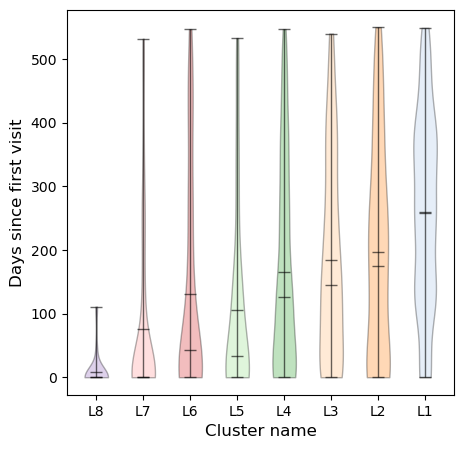

In [152]:
#males
dataset_hm = data_heatmap.query("sex == 0")
heatmap_plot(dataset_hm)

In [153]:
general_dataset = Propensity(         data_heatmap,                    
                    time_column= "days",
                    label_column = "label",
                    patient_indetifier= "PATNR",
                    med_array=dmards,)
general_dataset.calc_transition_matrix()
pd_from_total = general_dataset.traject_props

male_dataset = Propensity(data_heatmap.query('sex==0'),                    
                    time_column= "days",
                    label_column = "label",
                    patient_indetifier= "PATNR",
                    med_array=dmards,)
male_dataset.calc_transition_matrix()
female_dataset = Propensity(data_heatmap.query('sex==1'),                    
                    time_column= "days",
                    label_column = "label",
                    patient_indetifier= "PATNR",
                    med_array=dmards,)
female_dataset.calc_transition_matrix()


/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/propensity.py:33: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)
/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/propensity.py:33: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)
/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/propensity.py:33: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)


/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/propensity.py:33: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)


Text(0.5, 1.0, 'general trajetories')

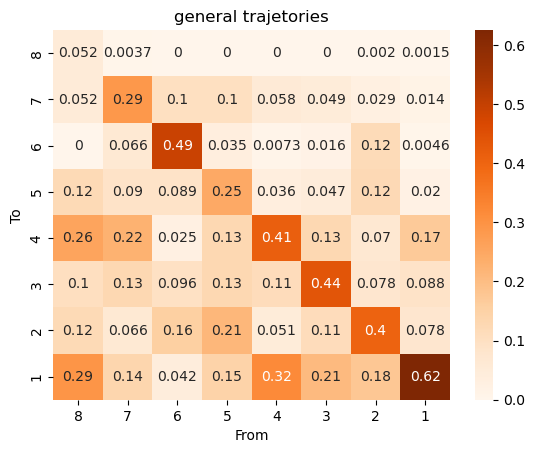

In [154]:
general_dataset = Propensity(         data_heatmap,                    
                    time_column= "days",
                    label_column = "label",
                    patient_indetifier= "PATNR",
                    med_array=dmards,)
general_dataset.calc_transition_matrix()
pd_from_total = general_dataset.traject_props
ax = sns.heatmap(general_dataset.traject_props, cmap='Oranges', annot=True)
ax.set_ylabel("To")
ax.set_xlabel("From")
ax.set_title("general trajetories")

Text(0.5, 1.0, 'Male')

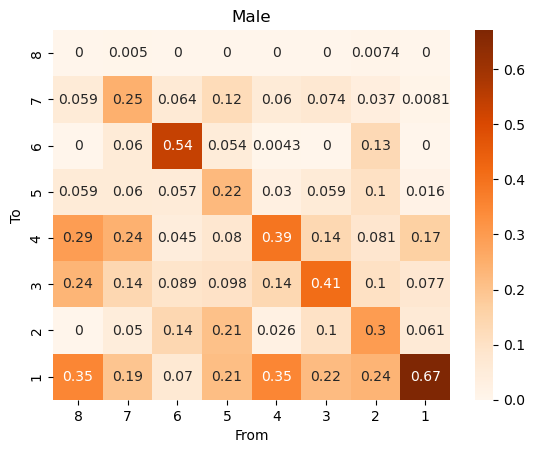

In [155]:
ax = sns.heatmap(male_dataset.traject_props, cmap='Oranges', annot=True)
ax.set_ylabel("To")
ax.set_xlabel("From")
ax.set_title("Male")

Text(0.5, 1.0, 'Female')

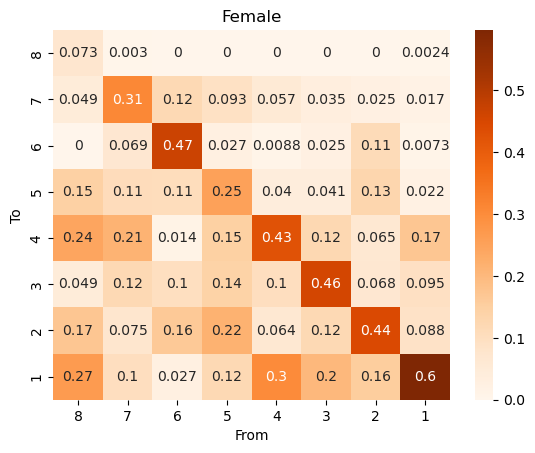

In [156]:
ax = sns.heatmap(female_dataset.traject_props, cmap='Oranges', annot=True)
ax.set_ylabel("To")
ax.set_xlabel("From")
ax.set_title("Female")

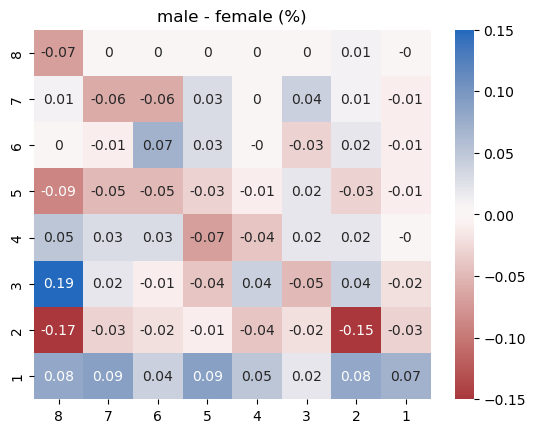

In [157]:
ax = sns.heatmap((male_dataset.traject_props-female_dataset.traject_props).round(2), cmap='vlag_r', annot=True, vmin=-0.15, vmax=0.15)
ax.set_title("male - female (%)")
plt.show()

In [158]:

acpa_neg_dataset = Propensity(data_heatmap.query("`aCCP positive`==0"),                    
                    time_column= "days",
                    label_column = "label",
                    patient_indetifier= "PATNR",
                    med_array=dmards,)
acpa_neg_dataset.calc_transition_matrix()
acpa_pos_dataset = Propensity(data_heatmap.query("`aCCP positive`==1"),                    
                    time_column= "days",
                    label_column = "label",
                    patient_indetifier= "PATNR",
                    med_array=dmards,)
acpa_pos_dataset.calc_transition_matrix()


/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/propensity.py:33: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)
/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/propensity.py:33: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)


In [159]:
acpa_neg_dataset.count_patients

666

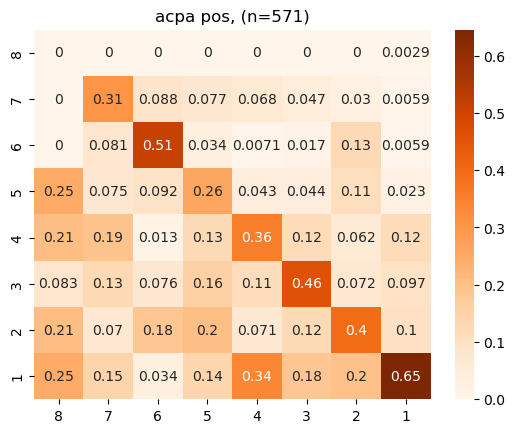

Text(0.5, 1.0, 'acpa neg, (n=666)')

Error in callback <function flush_figures at 0x7fb44ca41a80> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [160]:

ax = sns.heatmap(acpa_pos_dataset.traject_props, cmap='Oranges', annot=True)
ax.set_title(f"acpa pos, (n={acpa_pos_dataset.count_patients})")
plt.show()
ax = sns.heatmap(acpa_neg_dataset.traject_props, cmap='Oranges', annot=True)
ax.set_title(f"acpa neg, (n={acpa_neg_dataset.count_patients})")

In [161]:
rf_neg_dataset = Propensity(data_heatmap.query("`RF positive`==0"),                    
                    time_column= "days",
                    label_column = "label",
                    patient_indetifier= "PATNR",
                    med_array=dmards,)
rf_neg_dataset.calc_transition_matrix()
rf_pos_dataset = Propensity(data_heatmap.query("`RF positive`==1"),                    
                    time_column= "days",
                    label_column = "label",
                    patient_indetifier= "PATNR",
                    med_array=dmards,)
rf_pos_dataset.calc_transition_matrix()


/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/propensity.py:33: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)
/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/propensity.py:33: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)


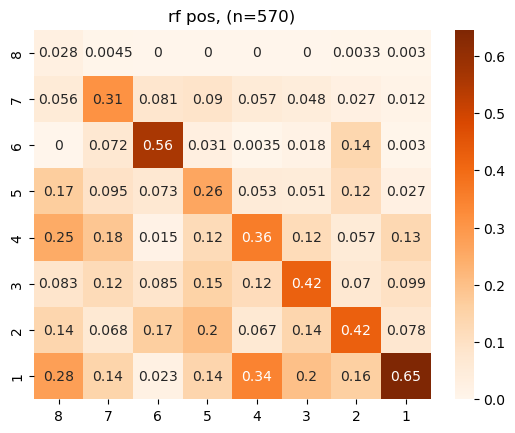

Text(0.5, 1.0, 'rf neg, (n=667)')

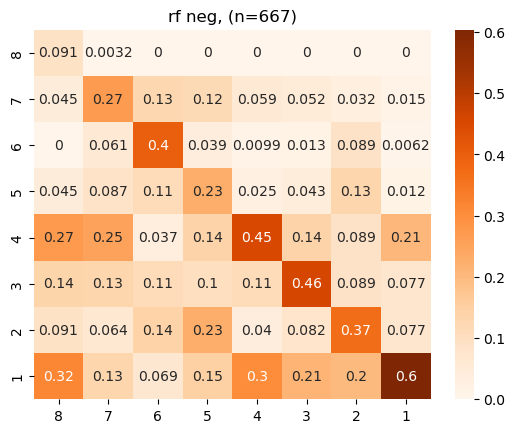

In [162]:

ax = sns.heatmap(rf_pos_dataset.traject_props, cmap='Oranges', annot=True)
ax.set_title(f"rf pos, (n={rf_pos_dataset.count_patients})")
plt.show()
ax = sns.heatmap(rf_neg_dataset.traject_props, cmap='Oranges', annot=True)
ax.set_title(f"rf neg, (n={rf_neg_dataset.count_patients})")

,8,7,6,5,4,3,2,1
8,-0.063131,0.001299,0.000000,0.000000,0.000000,0.000000,0.003344,0.003003
7,0.010101,0.041580,-0.046890,-0.026981,-0.002668,-0.003883,-0.004823,-0.003468
6,0.000000,0.011175,0.158756,-0.007499,-0.006355,0.005439,0.047650,-0.003189
5,0.121212,0.008056,-0.038625,0.032312,0.028439,0.008364,-0.014522,0.014643
4,-0.022727,-0.068520,-0.021849,-0.017813,-0.094814,-0.016460,-0.032617,-0.075298
3,-0.053030,-0.009789,-0.027087,0.052466,0.005635,-0.037982,-0.019240,0.021700
2,0.047980,0.003465,0.021768,-0.025984,0.027772,0.057649,0.056328,0.000679
1,-0.040404,0.012734,-0.046072,-0.006502,0.041991,-0.013127,-0.036120,0.041930


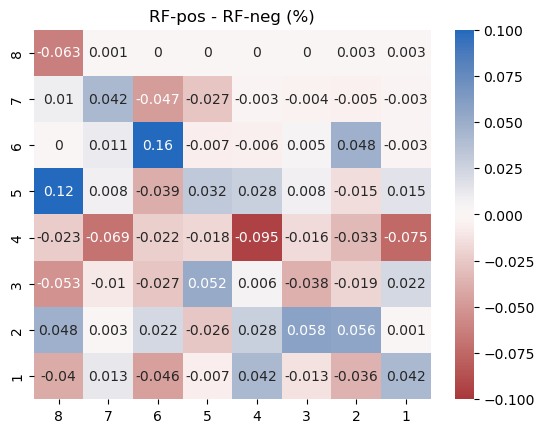

In [163]:
x = (rf_pos_dataset.traject_props-rf_neg_dataset.traject_props).copy().replace(np.inf,np.NaN)
ax = sns.heatmap(x.round(3), annot=True,  cmap='vlag_r', vmin=-0.1,vmax=0.1)
ax.set_title("RF-pos - RF-neg (%)")
x

In [164]:
#data_heatmap.to_csv(data_dir+"leiden_cluster_data_2.csv", index=False)